# 개요 : X-RAY 이미지를 기반으로 하는 폐렴 진단 딥러닝 모델을 제작

# 목차
  - 1)  X-RAY 이미지
      - 1-1) 의료영상 자세 분류
         - Sagittal plane : 시상면. 사람을 왼쪽과 오른쪽을 나누는 면.
         - Coronal plane : 관상면. 인체를 앞뒤로 나누는 면.
         - Transverse plane : 횡단면(수평면). 인체를 상하로 나누는 면.
         
           * 데이터는 모두 관상면 이미지임
           * 영상의 좌우는, 우리가 보는 입장에서는 좌우가 바꿔서 표시된다. (환자입장에서 죄우가 맞다)
          
         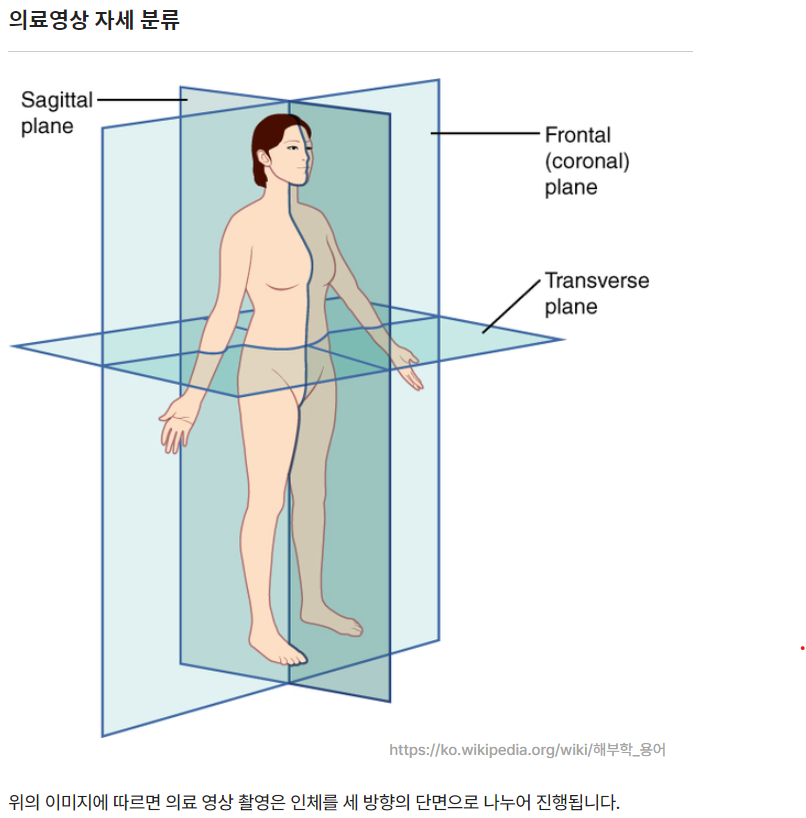
         
         
  - 2) X-RAY 특성
      - X-RAY는 전자기파가 몸을 통과한 결과를 이미지화 시킨 것, 통과하고 남은 전자기파의 결과로 흑백 명암으로 나옴
      - 뼈 : 하얀색, 근육 및 지방 : 연한 회색, 공기 : 검은색
      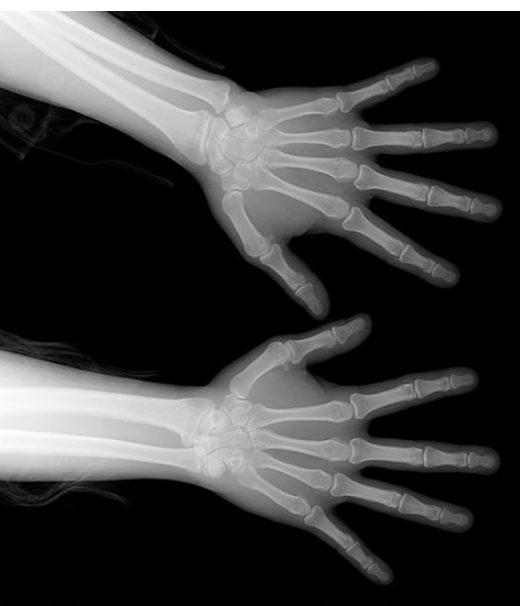
      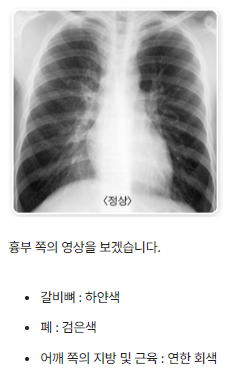
      
 - 3) 폐렴진단
    - 데이터셋 : 캐글의 Chest X-Ray Images (5,856 개의 X-Ray 이미지 (JPEG), 2 개의 범주 (폐렴 / 정상), 전체크기: 1.2GB)
    - 데이터폴더 : ~/aiffel/chest_xray/data 하위에 3개의 폴더 (train, test, val)로 구성
    - 폐렴(pneumonia 뉴모니아)은 폐에 염증이 생긴 상태로 중증의 호흡기 감염병, 흡인성 폐렴발생
       * 염증은 유해한 자극에 대한 생체반응 중 하나로 면역세포, 혈관, 염증 매개체들이 관여하는 보호반응이다.
       * 염증의 목적은 세포의 손상을 초기 단계에서 억제하고, 상처 부분의 파괴된 조직 및 괴사된 세포를 제거하며, 
         동시에 조직을 재생하는 것이다
       * 폐렴구별법 : X-RAY 사진상, 다양한 양상의 음영(폐 부위에 희미한 그림자) 증가가 관찰
       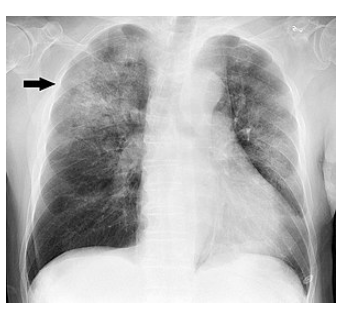
       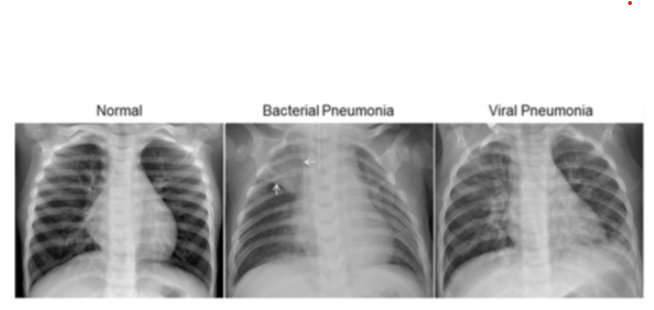
       * 정상 / 세균성 폐렴 / 바이러스성 폐렴 사진참조

# 주석및 의견

# summary

  - 모델은 테스트 데이터를 실행하고 예측을 수행한 다음 실제 레이블과 비교합니다 
  - 테스트 세트에서 모델의 예측 오류가 중간 수준(0.3446665108203888)
  - 모델이 페렴진단을 정확도 87.5%로 계산하며, 의료 보조 용도로는 어느 정도 쓸만한 모델로 판단됨  
  
  - Loss(손실율): 0.3446665108203888,
  - Accuracy(정확도): 0.875,
  - Precision(정밀도): 0.8768116235733032,
  - Recall(재현율): 0.9307692050933838

# 회고

 - X-RAY 이미지를 기반으로 하는 폐렴 진단 딥러닝 모델을 제작해보았다.
 - CNN 모델을 직접구성하여 모델을 제작했다.
 - 한 라벨이 너무 많은 경우 imbalance 문제 해결을 위해, 파라미터로 class_weight 값을 세팅하여 가중치값을 조정했다.

# reference
 - 아래 제공되는 실습코드는 이 캐글 노트북을 기반으로 작성된 것을 참조함
 - https://www.kaggle.com/code/amyjang/tensorflow-pneumonia-classification-on-x-rays

# X-RAY 이미지를 기반으로 하는 폐렴 진단 딥러닝 모델제작 Project

# 1. Set-up

In [18]:
#1. X-RAY 이미지를 기반으로 하는 폐렴 진단 딥러닝 모델을 제작

#------------------------
# 패키지(라이브러리)들을 import
#------------------------
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
#------------------------
# 변수들을 생성
#------------------------

# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10

print(ROOT_PATH)

/aiffel/aiffel


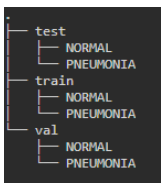 (디렉토리 구조참조)

# 2. 데이터 가져오기

In [3]:
# 2. 데이터 가져오기
train_filenames = tf.io.gfile.glob(TRAIN_PATH)  #학습데이타
test_filenames = tf.io.gfile.glob(TEST_PATH)  #test데이타
val_filenames = tf.io.gfile.glob(VAL_PATH)  #검증데이타

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
#------------------------------------------------------------------------------------------------------
#train과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할 (val 개수가 너무 없기 때문에)
#------------------------------------------------------------------------------------------------------

# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
#train 데이터 안에 정상 이미지 수와 폐렴 이미지 수 확인
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


In [6]:
#파일경로 기준으로 train 데이터 안에 정상 이미지 수와 폐렴 이미지 수 확인하기
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


- CNN 모델의 경우 데이터가 클래스별 balance가 좋을수록 training을 잘 합니다
- 데이터가 클래스 불균형(imbalance)한 것은 차후에 조정할 예정

- Batch Size :머신러닝이 데이터를 학습하는 과정에서 최적화(Gradient descent) 할 때 한번에 몇개의 데이터를 가지고 하는 지를 나타낸다

- Batch Size 는 왜 생겼을까?
  * 데이터가 엄청나게 많은 경우 전체데이터를 보고 최적화를 할 때 엄청난 시간이 할애할 수 있다.
  * 그래서 정확도는 좀 떨어지지만 Batch Size를 줄여서 시간을 단축시키는 것이다.

In [8]:
#tf.data 인스턴스 생성
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [9]:
#Train 데이터셋, validation 데이터셋 개수 확인

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [12]:
#--------------------------------
#라벨 데이터 생성 함수작성
#--------------------------------

# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [13]:
#--------------------------------
#이미지의 사이즈를 통일 (사이즈줄이기)
#--------------------------------

# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [14]:
#train 데이터 셋과 validation 데이터 셋 생성

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [15]:
#수정된 이미지 사이즈 및 라벨 확인

for image, label in train_ds.take(1):  #하나의 데이터만 가져와서 확인
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [16]:
#test 데이터셋 생성
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()  #test데이타셋 데이터 개수
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)  #16으로 설정

print(TEST_IMAGE_COUNT)

624


In [17]:
#데이터 변환

def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)  #고정크기 버퍼를 유지, 무작위로 균일하게 다음 요소를 선택
    ds = ds.repeat()                                  #자동으로 데이터를 맞춰준다
    ds = ds.batch(BATCH_SIZE)                         #BATCH_SIZE:16
    ds = ds.prefetch(buffer_size=AUTOTUNE)            #학습 데이터를 나눠서 읽어온다
    return ds 

train_ds = prepare_for_training(train_ds)     #학습데이타셋
val_ds = prepare_for_training(val_ds)         #검증데이타셋

# 3. 데이터 시각화
  -  train에 있는 batch 중 첫 번째 배치를 추출
  -  추출된 배치를 image와 label 데이터 셋으로 나눕니다
  -  show_batch() 함수를 이용해서 결과 사진 보기

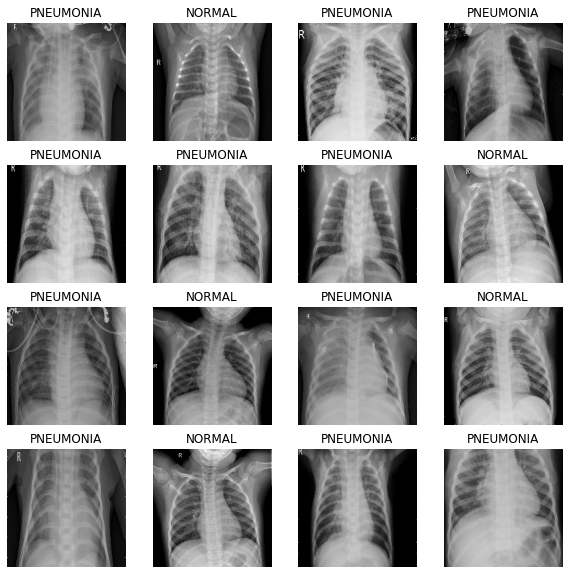

In [20]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        
        # 하위플롯의 그리드생성(행수:4, 서브플롯 그리드의 열수:16/4=4, 현재 서브플롯의 위치:n+1(1) )
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)  
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# 4. CNN 모델링
  - Convolution block 생성
  - conv_block()의 구성은 Convolution을 두 번 진행
  - Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding을 해결
  - Max Pooling을 합니다

In [24]:
# Convolution block 생성

def conv_block(filters):
    block = tf.keras.Sequential([
        #깊이별 분리 합성곱( 필터 개수 , 커널 크기 , 활성화 함수 (ReLU와 같은), 패딩)
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),   #계층의 활성화를 정규화
        tf.keras.layers.MaxPool2D() #
    ])
    
    return block

In [25]:
# Dense Block 생성

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [28]:
# CNN 모델은 약간의 수정을 거쳐 만들어진 모델
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# 5. 데이터 imbalance 처리

 - imbalance : 한 라벨이 너무 많은 경우
 - 데이터를 학습할 때 imbalance한 데이터의 경우 학습 효과가 좋지 않을 수 있습니다
 - 해결하는 방법 : Weight balancing이라는 테크닉이 사용
    - Weight balancing: training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법
    - Keras는 model.fit()을 호출할 때 파라미터로 넘기는 class_weight 에 이러한 클래스별 가중치를 세팅할 수 있도록 지원

In [29]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0       #Normal 이미지에 사용할 weight 세팅
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0    #Pneumonia이미지에 사용할 weight 세팅

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


# 6. 모델 훈련

   - 이미지 훈련은 GPU를 선택
   - build_model()을 model에 선언
   - 라벨이 두개(loss) : binary_cross entropy loss를 사용
   - optimizer : adam 사용
   - 성과측정 : metrics 는 'accuracy', 'precision', 'recall'을 사용 

In [30]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [31]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,   #4185/16 = 261개
        epochs=EPOCHS,                                   #EPOCHS = 10
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,    #1047/16 = 65개
        class_weight=class_weight,                       #Weight for NORMAL: 1.96, Weight for PNEUMONIA: 0.67
    )

Epoch 1/10
261/261 [==============================] - 117s 225ms/step - loss: 0.4353 - accuracy: 0.7737 - precision: 0.9486 - recall: 0.7359 - val_loss: 0.6023 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 55s 210ms/step - loss: 0.2361 - accuracy: 0.9090 - precision: 0.9713 - recall: 0.9045 - val_loss: 1.2847 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 55s 211ms/step - loss: 0.2059 - accuracy: 0.9212 - precision: 0.9734 - recall: 0.9192 - val_loss: 0.2303 - val_accuracy: 0.8894 - val_precision: 0.8699 - val_recall: 0.9987
Epoch 4/10
261/261 [==============================] - 56s 216ms/step - loss: 0.1907 - accuracy: 0.9294 - precision: 0.9795 - recall: 0.9243 - val_loss: 1.2867 - val_accuracy: 0.5827 - val_precision: 1.0000 - val_recall: 0.4312
Epoch 5/10
261/261 [==============================] - 57s 218ms/step - loss: 0.1615 - accur

# 7. 결과 확인

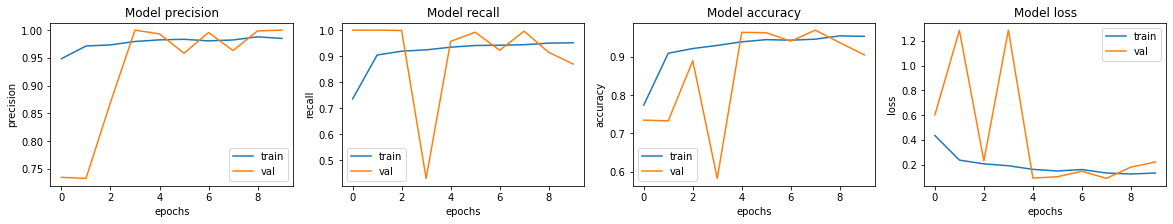

In [32]:
#  Epochs 마다 모델의 precision, recall, accuracy, loss 변화 확인

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [33]:
#테스트 데이터로 모델 평가 (loss, accuracy, precision, recall 값을 출력)
loss, accuracy, precision, recall = model.evaluate(test_ds)  #손실:loss, 정확도:accuracy, 정밀도:precision, 재현율:recall
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 122ms/step - loss: 0.3447 - accuracy: 0.8750 - precision: 0.8768 - recall: 0.9308
Loss: 0.3446665108203888,
Accuracy: 0.875,
Precision: 0.8768116235733032,
Recall: 0.9307692050933838
